# MLP Counter Composition Visualization

This notebook trains the tiny `phantom.counters` MLP on the current hand-written counter table and visualizes predicted compositions for selected enemy units.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sc2.ids.unit_typeid import UnitTypeId

from phantom.counters import (
    CounterFeatureSpace,
    TinyMLPComposition,
    TinyMLPCompositionConfig,
    build_training_dataset,
    decode_target_distribution,
)

In [2]:
feature_space = CounterFeatureSpace.default()
examples = build_training_dataset(feature_space)
config = TinyMLPCompositionConfig(hidden_size=12, epochs=500, learning_rate=0.15, l2=1e-4, seed=7)
model = TinyMLPComposition.from_feature_space(feature_space, hidden_size=config.hidden_size, seed=config.seed)
model.fit_examples(examples, config=config)

print(f'feature dim: {feature_space.dimension}')
print(f'examples: {len(examples)}')
print(f'parameter count: {model.parameter_count}')

feature dim: 142
examples: 47
parameter count: 3562


In [3]:
def top_items(distribution: np.ndarray, budget: float = 100.0, top_k: int = 6):
    decoded = decode_target_distribution(distribution, feature_space, budget=budget, top_k=top_k)
    return list(decoded.items())

def plot_enemy(enemy_type: UnitTypeId, budget: float = 100.0, top_k: int = 6):
    row = next(example for example in examples if example.enemy_type == enemy_type)
    pred = model.predict_distribution(row.enemy_vector)

    target_items = top_items(row.target_vector, budget=budget, top_k=top_k)
    pred_items = top_items(pred, budget=budget, top_k=top_k)

    target_labels = [unit.name for unit, _ in target_items]
    target_values = [value for _, value in target_items]

    pred_labels = [unit.name for unit, _ in pred_items]
    pred_values = [value for _, value in pred_items]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(target_labels, target_values)
    axes[0].set_title(f'Target counters for {enemy_type.name}')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel('Budget allocation')

    axes[1].bar(pred_labels, pred_values)
    axes[1].set_title(f'MLP prediction for {enemy_type.name}')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

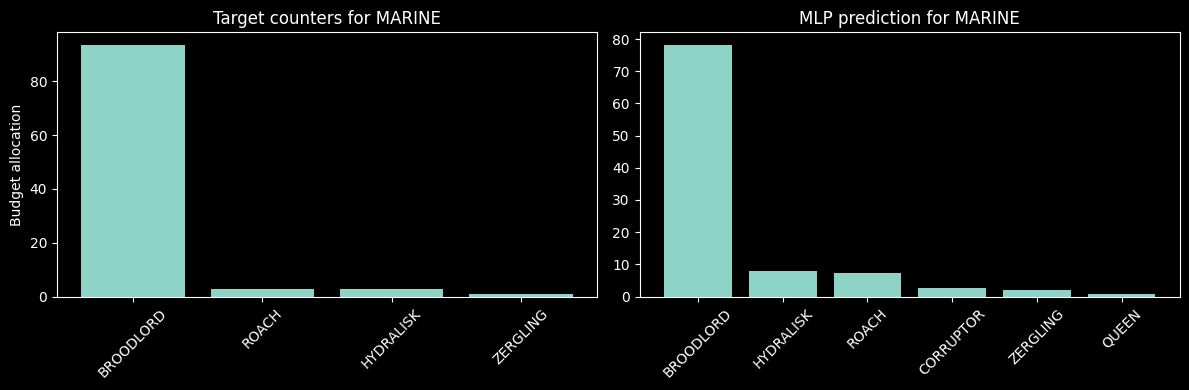

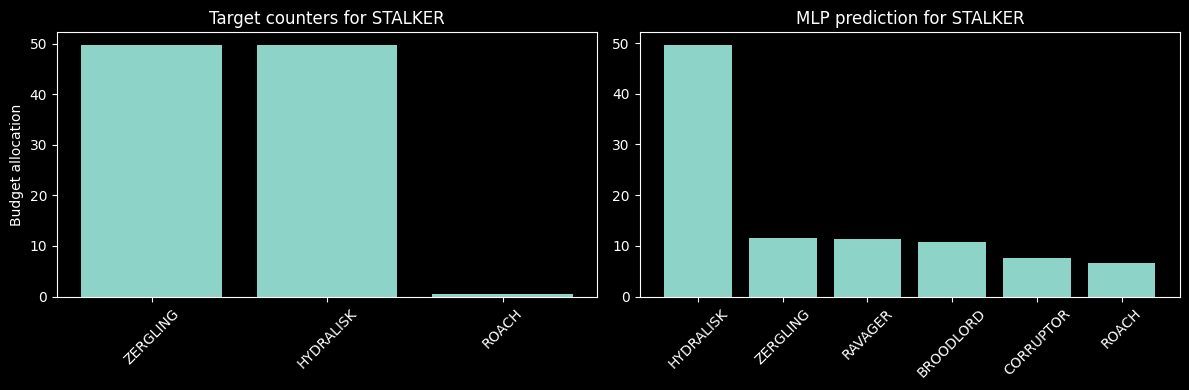

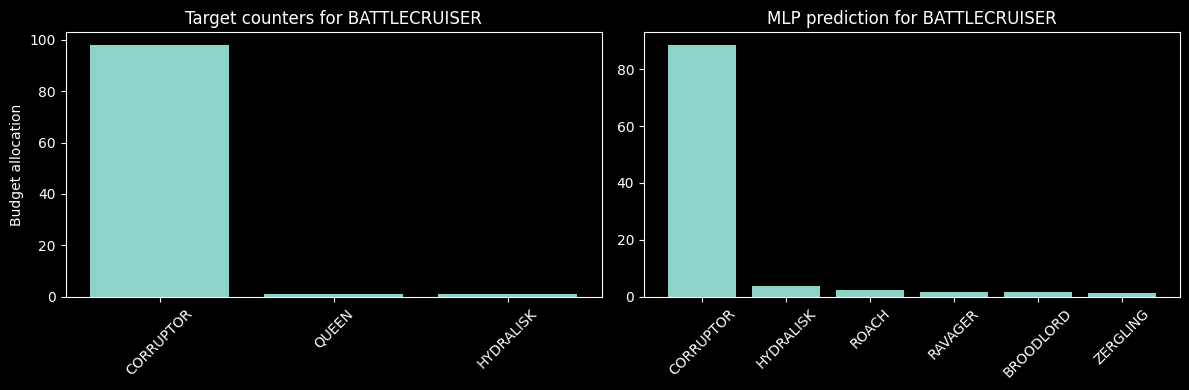

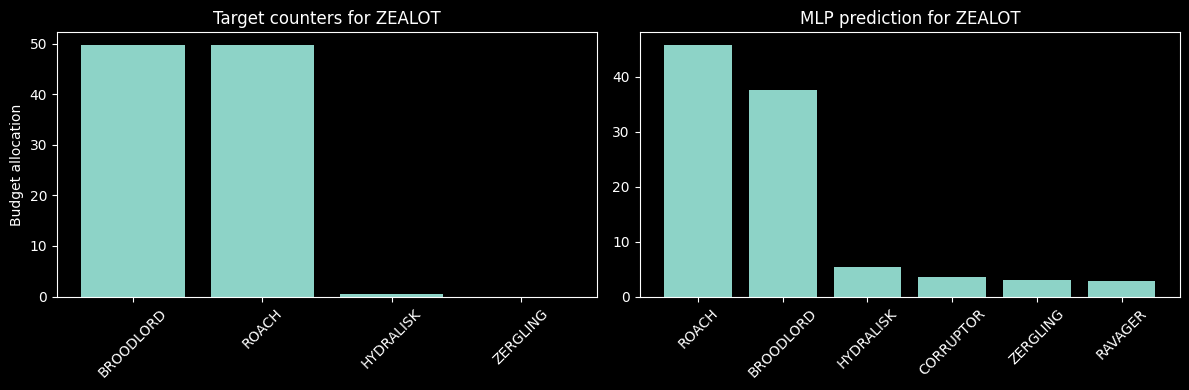

In [4]:
for enemy in [UnitTypeId.MARINE, UnitTypeId.STALKER, UnitTypeId.BATTLECRUISER, UnitTypeId.ZEALOT]:
    plot_enemy(enemy, budget=100.0, top_k=6)